In [2]:
import torch
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [3]:
import torch.nn as nn
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [4]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, train_loader, optimizer, loss_fn, print_every=100):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
#         if iteration % print_every == 0:
#             print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
#     print('Test average loss: {:.4f}, accuracy: {:.3f}'.format(average_loss, accuracy))
    return average_loss, accuracy


def fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if scheduler:
            scheduler.step() # argument only needed for ReduceLROnPlateau
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
    
    return val_accuracies

In [5]:
transform_dataset = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

In [6]:
train_dataset = datasets.ImageFolder('mnist/train',transform=transform_dataset)

In [7]:
val_dataset = datasets.ImageFolder('mnist/val',transform=transform_dataset)

In [8]:
test_dataset = datasets.ImageFolder('mnist/test',transform=transform_dataset)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100, shuffle=True)

In [10]:
for tensor in train_loader:
    print(tensor[0].shape)
    break
for tensor in val_loader:
    print(tensor[0].shape)
    break

torch.Size([100, 3, 28, 28])
torch.Size([100, 3, 28, 28])


Epoch 1/25: train_loss: 0.5778, train_accuracy: 81.2637, val_loss: 0.3480, val_accuracy: 89.2576
Epoch 2/25: train_loss: 0.2853, train_accuracy: 91.0025, val_loss: 0.2562, val_accuracy: 91.8232
Epoch 3/25: train_loss: 0.2236, train_accuracy: 92.9303, val_loss: 0.2043, val_accuracy: 93.3586
Epoch 4/25: train_loss: 0.1856, train_accuracy: 94.2488, val_loss: 0.1659, val_accuracy: 94.9495
Epoch 5/25: train_loss: 0.1689, train_accuracy: 94.6418, val_loss: 0.1566, val_accuracy: 95.0859
Epoch 6/25: train_loss: 0.1508, train_accuracy: 95.2886, val_loss: 0.1796, val_accuracy: 94.3434
Epoch 7/25: train_loss: 0.1254, train_accuracy: 95.9478, val_loss: 0.1340, val_accuracy: 95.8889
Epoch 8/25: train_loss: 0.1255, train_accuracy: 95.9428, val_loss: 0.1304, val_accuracy: 96.0253
Epoch 9/25: train_loss: 0.1153, train_accuracy: 96.3657, val_loss: 0.1093, val_accuracy: 96.6111
Epoch 10/25: train_loss: 0.1022, train_accuracy: 96.6990, val_loss: 0.1309, val_accuracy: 96.0404
Epoch 11/25: train_loss: 0.10

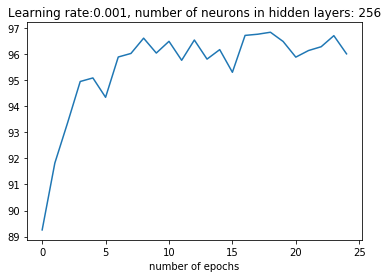

Epoch 1/25: train_loss: 0.5843, train_accuracy: 80.5871, val_loss: 0.3131, val_accuracy: 90.0657
Epoch 2/25: train_loss: 0.2957, train_accuracy: 90.7388, val_loss: 0.2921, val_accuracy: 90.2929
Epoch 3/25: train_loss: 0.2414, train_accuracy: 92.2861, val_loss: 0.2452, val_accuracy: 92.5707
Epoch 4/25: train_loss: 0.2180, train_accuracy: 93.1169, val_loss: 0.2073, val_accuracy: 93.5657
Epoch 5/25: train_loss: 0.1912, train_accuracy: 94.0373, val_loss: 0.1820, val_accuracy: 94.3586
Epoch 6/25: train_loss: 0.1734, train_accuracy: 94.4900, val_loss: 0.1635, val_accuracy: 95.0152
Epoch 7/25: train_loss: 0.1568, train_accuracy: 95.1020, val_loss: 0.2140, val_accuracy: 93.6263
Epoch 8/25: train_loss: 0.1493, train_accuracy: 95.3259, val_loss: 0.1571, val_accuracy: 95.2222
Epoch 9/25: train_loss: 0.1359, train_accuracy: 95.6716, val_loss: 0.1624, val_accuracy: 95.2727
Epoch 10/25: train_loss: 0.1285, train_accuracy: 95.9279, val_loss: 0.1537, val_accuracy: 95.5303
Epoch 11/25: train_loss: 0.13

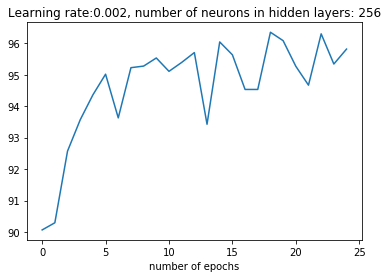

Epoch 1/25: train_loss: 0.8925, train_accuracy: 72.2189, val_loss: 0.5263, val_accuracy: 83.8232
Epoch 2/25: train_loss: 0.4651, train_accuracy: 85.7687, val_loss: 0.5757, val_accuracy: 81.7576
Epoch 3/25: train_loss: 0.4431, train_accuracy: 86.5075, val_loss: 0.4654, val_accuracy: 86.2727
Epoch 4/25: train_loss: 0.4243, train_accuracy: 87.3781, val_loss: 0.4266, val_accuracy: 86.8586
Epoch 5/25: train_loss: 0.4264, train_accuracy: 87.2587, val_loss: 0.4478, val_accuracy: 86.4091
Epoch 6/25: train_loss: 0.4074, train_accuracy: 87.9900, val_loss: 0.3939, val_accuracy: 88.0808
Epoch 7/25: train_loss: 0.4141, train_accuracy: 87.5846, val_loss: 0.3772, val_accuracy: 89.1061
Epoch 8/25: train_loss: 0.4073, train_accuracy: 88.0199, val_loss: 0.3943, val_accuracy: 87.9949
Epoch 9/25: train_loss: 0.3851, train_accuracy: 88.8483, val_loss: 0.3597, val_accuracy: 89.6061
Epoch 10/25: train_loss: 0.3903, train_accuracy: 88.5771, val_loss: 0.3566, val_accuracy: 89.4192
Epoch 11/25: train_loss: 0.39

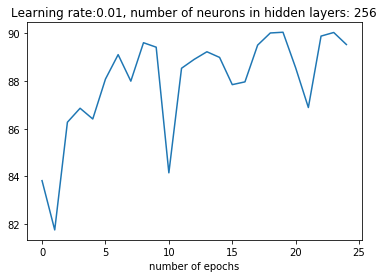

Epoch 1/25: train_loss: 0.5462, train_accuracy: 82.0920, val_loss: 0.3424, val_accuracy: 89.3889
Epoch 2/25: train_loss: 0.2887, train_accuracy: 90.7736, val_loss: 0.2498, val_accuracy: 92.1515
Epoch 3/25: train_loss: 0.2185, train_accuracy: 93.1990, val_loss: 0.2005, val_accuracy: 93.7273
Epoch 4/25: train_loss: 0.1863, train_accuracy: 94.0124, val_loss: 0.2001, val_accuracy: 93.6869
Epoch 5/25: train_loss: 0.1653, train_accuracy: 94.5920, val_loss: 0.1465, val_accuracy: 95.3737
Epoch 6/25: train_loss: 0.1406, train_accuracy: 95.4677, val_loss: 0.1505, val_accuracy: 95.3939
Epoch 7/25: train_loss: 0.1342, train_accuracy: 95.6940, val_loss: 0.1508, val_accuracy: 95.2323
Epoch 8/25: train_loss: 0.1203, train_accuracy: 96.0323, val_loss: 0.1525, val_accuracy: 95.2778
Epoch 9/25: train_loss: 0.1081, train_accuracy: 96.4726, val_loss: 0.1245, val_accuracy: 96.1364
Epoch 10/25: train_loss: 0.1016, train_accuracy: 96.7612, val_loss: 0.1538, val_accuracy: 95.1010
Epoch 11/25: train_loss: 0.09

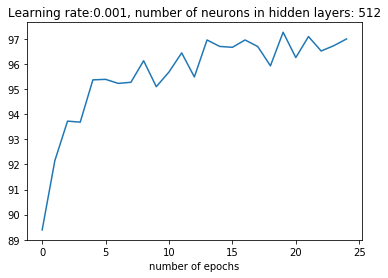

Epoch 1/25: train_loss: 0.6340, train_accuracy: 78.5249, val_loss: 0.4431, val_accuracy: 85.7323
Epoch 2/25: train_loss: 0.3044, train_accuracy: 90.3532, val_loss: 0.2861, val_accuracy: 90.7525
Epoch 3/25: train_loss: 0.2405, train_accuracy: 92.4229, val_loss: 0.2323, val_accuracy: 93.0051
Epoch 4/25: train_loss: 0.1940, train_accuracy: 94.0597, val_loss: 0.2656, val_accuracy: 91.7424
Epoch 5/25: train_loss: 0.1808, train_accuracy: 94.3209, val_loss: 0.1742, val_accuracy: 94.5303
Epoch 6/25: train_loss: 0.1775, train_accuracy: 94.4602, val_loss: 0.1650, val_accuracy: 94.8687
Epoch 7/25: train_loss: 0.1604, train_accuracy: 94.9726, val_loss: 0.1583, val_accuracy: 95.3485
Epoch 8/25: train_loss: 0.1444, train_accuracy: 95.3657, val_loss: 0.1825, val_accuracy: 94.4697
Epoch 9/25: train_loss: 0.1343, train_accuracy: 95.7363, val_loss: 0.1447, val_accuracy: 95.8737
Epoch 10/25: train_loss: 0.1328, train_accuracy: 95.8333, val_loss: 0.1239, val_accuracy: 96.2374
Epoch 11/25: train_loss: 0.12

In [ ]:
nb_epochs = 25
i = 0
for hidden_layers in [256,512]:
    for learning_rate in [0.001,0.002,0.01]:
        model_mlp = MLPModel(3*28*28, hidden_layers)
        model_mlp = model_mlp.to(device)
        optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()
        accuracies = fit(train_loader, val_loader, model_mlp, optimizer, loss_fn, nb_epochs)
        plt.title('Learning rate:' + str(learning_rate) + ', number of neurons in hidden layers: ' + str(hidden_layers))
        plt.plot(accuracies)
        plt.xlabel('number of epochs')
        plt.savefig('mlp_plot/'+str(i) + '.png')
        plt.show() 
        i = i + 1
        

Epoch 1/25: train_loss: 0.6345, train_accuracy: 79.0025, val_loss: 0.4693, val_accuracy: 85.3788
Epoch 2/25: train_loss: 0.3014, train_accuracy: 90.5274, val_loss: 0.1990, val_accuracy: 93.8737
Epoch 3/25: train_loss: 0.2417, train_accuracy: 92.3781, val_loss: 0.2332, val_accuracy: 92.7071
Epoch 4/25: train_loss: 0.2093, train_accuracy: 93.2289, val_loss: 0.2203, val_accuracy: 93.0253
Epoch 5/25: train_loss: 0.1813, train_accuracy: 94.4577, val_loss: 0.1701, val_accuracy: 95.0051
Epoch 6/25: train_loss: 0.1712, train_accuracy: 94.6119, val_loss: 0.1647, val_accuracy: 94.9899
Epoch 7/25: train_loss: 0.1606, train_accuracy: 94.9129, val_loss: 0.1744, val_accuracy: 94.7778
Epoch 8/25: train_loss: 0.1447, train_accuracy: 95.3532, val_loss: 0.2295, val_accuracy: 93.4444
Epoch 9/25: train_loss: 0.1473, train_accuracy: 95.2711, val_loss: 0.1982, val_accuracy: 94.1162
Epoch 10/25: train_loss: 0.1263, train_accuracy: 96.0348, val_loss: 0.1423, val_accuracy: 96.0455
Epoch 11/25: train_loss: 0.12

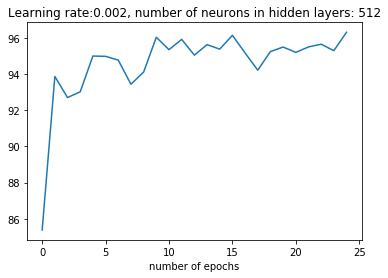

Epoch 1/25: train_loss: 1.8024, train_accuracy: 56.1269, val_loss: 0.8583, val_accuracy: 70.5606
Epoch 2/25: train_loss: 0.8120, train_accuracy: 72.5348, val_loss: 0.7600, val_accuracy: 74.4091
Epoch 3/25: train_loss: 0.7345, train_accuracy: 75.6741, val_loss: 0.6705, val_accuracy: 78.1162
Epoch 4/25: train_loss: 0.7354, train_accuracy: 75.6692, val_loss: 0.6838, val_accuracy: 77.7929
Epoch 5/25: train_loss: 0.6946, train_accuracy: 77.2836, val_loss: 0.7487, val_accuracy: 74.4798
Epoch 6/25: train_loss: 0.7096, train_accuracy: 76.6692, val_loss: 0.6830, val_accuracy: 76.7626
Epoch 7/25: train_loss: 0.7055, train_accuracy: 76.8905, val_loss: 0.6634, val_accuracy: 77.8737
Epoch 8/25: train_loss: 0.7031, train_accuracy: 76.9577, val_loss: 0.7235, val_accuracy: 76.1919
Epoch 9/25: train_loss: 0.6777, train_accuracy: 78.0398, val_loss: 0.6878, val_accuracy: 77.7677
Epoch 10/25: train_loss: 0.6688, train_accuracy: 77.9179, val_loss: 0.8614, val_accuracy: 70.1061
Epoch 11/25: train_loss: 0.68

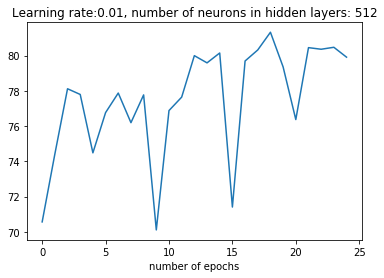

In [11]:
nb_epochs = 25
i = 0
for hidden_layers in [512]:
    for learning_rate in [0.002,0.01]:
        model_mlp = MLPModel(3*28*28, hidden_layers)
        model_mlp = model_mlp.to(device)
        optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()
        accuracies = fit(train_loader, val_loader, model_mlp, optimizer, loss_fn, nb_epochs)
        plt.title('Learning rate:' + str(learning_rate) + ', number of neurons in hidden layers: ' + str(hidden_layers))
        plt.plot(accuracies)
        plt.xlabel('number of epochs')
        plt.savefig('mlp_plot/'+str(i) + '.png')
        plt.show() 
        i = i + 1
        